# Plot accuracy between poison and clean data

In [1]:
%load_ext lab_black

In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from label_flip_revised.utils import open_csv
from label_flip_revised.simple_nn_model import SimpleModel
from label_flip_revised.torch_utils import evaluate, train_model

In [3]:
PATH_DATA = os.path.join(Path().absolute().parent, "data", "output")
DATA_NAME = "australian"

print(PATH_DATA)

/home/lukec/workspace/label_flip_revised/data/output


In [4]:
# For poison rates
STEP = 0.05
MAX_RATE = 0.51

# For training the classifier:
BATCH_SIZE = 128  # Size of mini-batch.
HIDDEN_LAYER = 128  # Number of hidden neurons in a hidden layer.
LR = 0.001  # Learning rate.
MAX_EPOCHS = 400  # Number of iteration for training.

In [5]:
# Load data
path_clean_train = os.path.join(PATH_DATA, "train", f"{DATA_NAME}_clean_train.csv")
X_train, y_train, _ = open_csv(path_clean_train)
print(f"Traning data shape: {X_train.shape}")

path_clean_test = os.path.join(PATH_DATA, "test", f"{DATA_NAME}_clean_test.csv")
X_test, y_test, _ = open_csv(path_clean_train)
print(f"Test data shape: {X_test.shape}")

# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dataloader for PyTorch
dataset_train = TensorDataset(
    torch.from_numpy(X_train).type(torch.float32),
    torch.from_numpy(y_train).type(torch.int64),
)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(
    torch.from_numpy(X_test).type(torch.float32),
    torch.from_numpy(y_test).type(torch.int64),
)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

Traning data shape: (552, 14)
Test data shape: (552, 14)


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("Running on CPU!")

n_features = X_train.shape[1]
model = SimpleModel(n_features, hidden_dim=HIDDEN_LAYER, output_dim=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.8)
loss_fn = nn.CrossEntropyLoss()

# Load pre-trained model
path_clf = os.path.join(PATH_DATA, "torch", f"{DATA_NAME}_SimpleNN.torch")
model.load_state_dict(torch.load(path_clf, map_location=device))

<All keys matched successfully>

In [7]:
acc_list_train = []
loss_list_train = []
acc_list_test = []
loss_list_test = []
poison_rate = [0.0]

acc_train, loss_train = evaluate(dataloader_train, model, loss_fn, device)
acc_test, loss_test = evaluate(dataloader_test, model, loss_fn, device)
acc_list_train.append(acc_train)
loss_list_train.append(loss_train)
acc_list_test.append(acc_test)
loss_list_test.append(loss_test)

print(
    f"[Clean] Train acc: {acc_train*100:.2f} loss: {loss_train:.3f}. Test acc: {acc_test*100:.2f} loss: {loss_test:.3f}"
)

[Clean] Train acc: 86.78 loss: 0.389. Test acc: 86.78 loss: 0.378


In [8]:
advx_range = np.arange(0, MAX_RATE, STEP)[1:]  # Remove 0%
print(advx_range)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [9]:
for p in advx_range:
    path_poison = os.path.join(PATH_DATA, "alfa_nn", f"{DATA_NAME}_nn_ALFA_{p:.2f}.csv")
    X_train, y_poison, _ = open_csv(path_poison)
    dataset_poison = TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_poison).type(torch.int64),
    )
    dataloader_poison = DataLoader(dataset_poison, batch_size=BATCH_SIZE, shuffle=True)

    model_poison = SimpleModel(n_features, hidden_dim=HIDDEN_LAYER, output_dim=2)
    model_poison = model_poison.to(device)
    optimizer_poison = torch.optim.SGD(model_poison.parameters(), lr=LR, momentum=0.8)

    train_model(
        model_poison, dataloader_poison, optimizer_poison, loss_fn, device, MAX_EPOCHS
    )

    acc_poison, loss_poison = evaluate(dataloader_poison, model_poison, loss_fn, device)
    acc_test, loss_test = evaluate(dataloader_test, model_poison, loss_fn, device)
    acc_list_train.append(acc_poison)
    loss_list_train.append(loss_poison)
    acc_list_test.append(acc_test)
    loss_list_test.append(loss_test)
    poison_rate.append(p)

    print(
        f"[{p:.2f}] Train acc: {acc_poison*100:.2f} loss: {loss_poison:.3f}. Test acc: {acc_test*100:.2f} loss: {loss_test:.3f}"
    )

[0.05] Train acc: 75.36 loss: 0.565. Test acc: 73.19 loss: 0.572
[0.10] Train acc: 81.70 loss: 0.458. Test acc: 82.61 loss: 0.465
[0.15] Train acc: 70.47 loss: 0.557. Test acc: 55.43 loss: 0.690
[0.20] Train acc: 64.49 loss: 0.572. Test acc: 44.57 loss: 0.710
[0.25] Train acc: 80.43 loss: 0.469. Test acc: 55.43 loss: 0.827
[0.30] Train acc: 74.46 loss: 0.471. Test acc: 44.57 loss: 0.807
[0.35] Train acc: 90.58 loss: 0.303. Test acc: 55.43 loss: 1.019
[0.40] Train acc: 84.42 loss: 0.408. Test acc: 44.57 loss: 0.966
[0.45] Train acc: 100.00 loss: 0.006. Test acc: 55.43 loss: 2.423
[0.50] Train acc: 94.57 loss: 0.188. Test acc: 44.57 loss: 1.274


In [10]:
data = {
    "rate": poison_rate,
    "acc.train": acc_list_train,
    "acc.test": acc_list_test,
    "loss.train": loss_list_train,
    "loss.test": loss_list_test,
}
df = pd.DataFrame(data)
df

,rate,acc.train,acc.test,loss.train,loss.test
0,0.00,0.867754,0.867754,0.389231,0.378345
1,0.05,0.753623,0.731884,0.565064,0.571887
2,0.10,0.817029,0.826087,0.457932,0.464891
3,0.15,0.704710,0.554348,0.556584,0.690481
4,0.20,0.644928,0.445652,0.572275,0.709855
5,0.25,0.804348,0.554348,0.469318,0.826834
6,0.30,0.744565,0.445652,0.470755,0.807188
7,0.35,0.905797,0.554348,0.303445,1.018917
8,0.40,0.844203,0.445652,0.407506,0.966245
9,0.45,1.000000,0.554348,0.006184,2.423303


/home/lukec/workspace/label_flip_revised/results/australian_acc.png


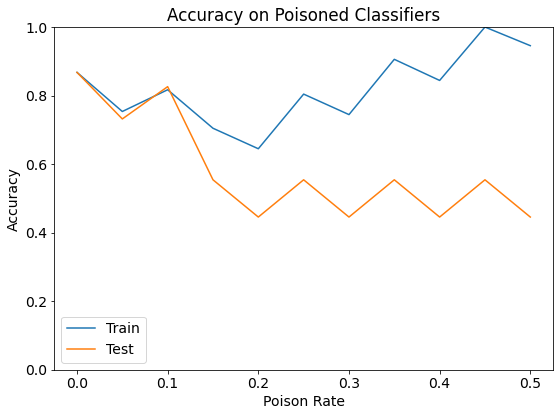

In [11]:
plt.rcParams["font.size"] = 14
fig, ax = plt.subplots(figsize=(8, 6))
df.plot(x="rate", y=["acc.train", "acc.test"], ax=ax)
ax.set_ylim([0, 1.0])
ax.legend(["Train", "Test"])
ax.set_xlabel("Poison Rate")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy on Poisoned Classifiers")
plt.tight_layout()

path_fig1 = os.path.join(Path().absolute().parent, "results", f"{DATA_NAME}_acc.png")
print(path_fig1)
plt.savefig(path_fig1, dpi=300, bbox_inches="tight")

/home/lukec/workspace/label_flip_revised/results/australian_loss.png


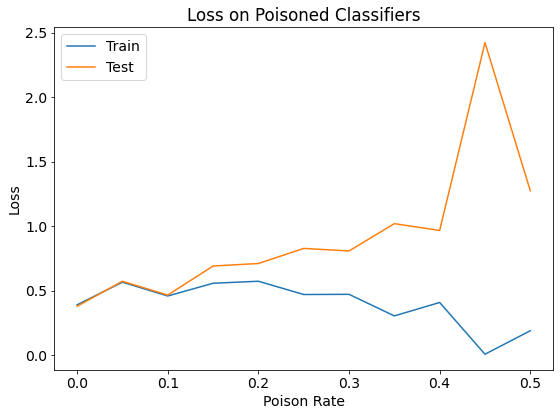

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
df.plot(x="rate", y=["loss.train", "loss.test"], ax=ax)
ax.legend(["Train", "Test"])
ax.set_xlabel("Poison Rate")
ax.set_ylabel("Loss")
ax.set_title("Loss on Poisoned Classifiers")
plt.tight_layout()

path_fig2 = os.path.join(Path().absolute().parent, "results", f"{DATA_NAME}_loss.png")
print(path_fig2)
plt.savefig(path_fig2, dpi=300, bbox_inches="tight")